In [1]:
"""
Script (do not modify)

set up environment and library
"""
!pip install -U opencv-contrib-python==3.4.0.12
import numpy as np
import cv2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 30.5MB 142kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
"""
Script (do not modify)
"""
# upload images 
from google.colab import files
uploaded = files.upload()

Saving yosemite1.jpg to yosemite1.jpg
Saving yosemite2.jpg to yosemite2.jpg


In [0]:
'''
Function (modify)
'''
def compute_homography(p1, p2):
  """
  compute homography transform matrix given 4 pairs of points

  Input:
  p1, p2: 4 x 2, 4 groups of corresponding points

  Output:
  H: 3 x 3, homography matrix
  """	
  # IMPLEMENT HERE, hint: you may find np.linalg.svd useful

  # construct the A matrix in the same way in the slides
  u_x = p2[:, 0]
  u_y = p2[:, 1]
  v_x = p1[:, 0]
  v_y = p1[:, 1]
  A = np.array([[u_x[0], u_y[0],      1,      0,      0,      0, -u_x[0] * v_x[0], -u_y[0] * v_x[0], -v_x[0]], 
                [     0,      0,      0, u_x[0], u_y[0],      1, -u_x[0] * v_y[0], -u_y[0] * v_y[0], -v_y[0]], 
                [u_x[1], u_y[1],      1,      0,      0,      0, -u_x[1] * v_x[1], -u_y[1] * v_x[1], -v_x[1]], 
                [     0,      0,      0, u_x[1], u_y[1],      1, -u_x[1] * v_y[1], -u_y[1] * v_y[1], -v_y[1]], 
                [u_x[2], u_y[2],      1,      0,      0,      0, -u_x[2] * v_x[2], -u_y[2] * v_x[2], -v_x[2]], 
                [     0,      0,      0, u_x[2], u_y[2],      1, -u_x[2] * v_y[2], -u_y[2] * v_y[2], -v_y[2]], 
                [u_x[3], u_y[3],      1,      0,      0,      0, -u_x[3] * v_x[3], -u_y[3] * v_x[3], -v_x[3]], 
                [     0,      0,      0, u_x[3], u_y[3],      1, -u_x[3] * v_y[3], -u_y[3] * v_y[3], -v_y[3]]])

  # use SVD to find the solution to Ax = 0
  U, D, VT = np.linalg.svd(A)

  # reorgnize the solution vector and normalize it to get homography matrix
  V = np.transpose(VT)
  X = V[:, -1] / V[-1, -1]
  H = np.reshape(X, (3, 3))

  return H

In [0]:
"""
Script (do not modify)
"""

p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ (115.0000,  120.0000),
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
                                [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
                                [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [0]:
'''
Function (modify)
'''

def match_features(f1,f2):
  """
  Match two sets of features

  Input:
  f1, f2: N x feature_size, two features to be matched

  Output:
  match, match_fwd, match_bkwd: N x 2, final matching result, forward matching result and backward matching result
  For each matching result, the first column is the index in f1 and the second column is the index in f2
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort, numpy.take_along_axis useful
  tol = 0.7
  
  # compute pairwise distance between f1 and f2
  pw_dist_fwd = cdist(f1, f2)
  pw_dist_bkwd = cdist(f2, f1)
  
  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  arg_fwd = np.argsort(pw_dist_fwd, axis=1)
  idx_fwd = arg_fwd[:, 0]
  dist_fwd = np.take_along_axis(pw_dist_fwd, arg_fwd, axis=1)

  # find closet two matches in f2 to f1
  d1_fwd = dist_fwd[:, 0]  # the closest distance
  d2_fwd = dist_fwd[:, 1]  # the second closest distance
  
  # ratio test
  ratio_fwd = d1_fwd / d2_fwd
  ratio_fwd_checked = np.nonzero(ratio_fwd < tol)[0]  # d1_fwd / d2_fwd < 0.7
  
  # forward matching result
  match_fwd = np.zeros((ratio_fwd_checked.shape[0], 2))
  match_fwd[:, 0] = ratio_fwd_checked
  match_fwd[:, 1] = idx_fwd[ratio_fwd_checked]

  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  arg_bkwd = np.argsort(pw_dist_bkwd, axis=1)
  idx_bkwd = arg_bkwd[:, 0]
  dist_bkwd = np.take_along_axis(pw_dist_bkwd, arg_bkwd, axis=1)

  # find closet two matches in f1 to f2
  d1_bkwd = dist_bkwd[:, 0]  # the closest distance
  d2_bkwd = dist_bkwd[:, 1]  # the second closest distance

  # ratio test
  ratio_bkwd = d1_bkwd / d2_bkwd
  ratio_bkwd_checked = np.nonzero(ratio_bkwd < tol)[0]  # d1_bkwd / d2_bkwd < 0.7

  # backward matching result
  match_bkwd = np.zeros((ratio_bkwd_checked.shape[0], 2))
  match_bkwd[:, 0] = idx_bkwd[ratio_bkwd_checked]
  match_bkwd[:, 1] = ratio_bkwd_checked

  # get the intersect of two matching as the final result
  match_two = np.concatenate((match_fwd, match_bkwd), axis=0)
  match_two = match_two[np.argsort(match_two[:, 0]), :]

  # bi-directional consistency check
  match_checked = []
  for i in range(match_two.shape[0] - 1):
    if (match_two[i, 0] == match_two[i + 1, 0]) and (match_two[i, 1] == match_two[i + 1, 1]):
      match_checked.append(match_two[i, :])

  # final result
  match = np.array(match_checked).astype(np.int32)

  return match, match_fwd, match_bkwd

In [0]:
'''
Function (modify)
'''

def ransac_homography(p1, p2):
  """
  estimate homography matrix with RANSAC
  
  Input:
  p1, p2: N x 2, correponding point coordinates

  Output:
  H: 3 x 3, estimated homography matrix
  """
  
  # IMPLEMENT HERE
  
  # decide how many loops to run and what the threshold is
  n = 4
  w = 0.8
  p = 0.999
  k = np.ceil(np.log(1 - p) / np.log(1 - (w ** n))).astype(np.int32)
  threshold = 1.35
  
  # RANSAC loop, inside in the loop
  N = p1.shape[0]
  best_e = 0
  best_H = np.eye(3)
  for j in range(k):
    # 1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
    n_samples = np.random.choice(N, n)

    # 2. fit the model and get a estimation
    H = compute_homography(p1[n_samples, :], p2[n_samples, :])

    # 3. count consensus(# of inliers that is close to the estimatiion within the threshold)
    n_inliers = 0
    for i in range(N):
      # from the lecture, Outlier Rejection with RANSAC
      u = np.array([[p2[i, 0]], [p2[i, 1]], [1]])
      Hu = np.dot(H, u)
      Hu = Hu[:2] / Hu[2]
      v = np.array([[p1[i, 0]], [p1[i, 1]]])
      d = np.sqrt(np.sum((v - Hu) ** 2))
      if (d < threshold):
        n_inliers += 1
    
    # 4. update the best estimation if the current one is better 
    if (n_inliers > best_e):
      best_e = n_inliers
      best_H = H
  
  return best_H

In [0]:
'''
Function (don't modify)
helper function to plot the correspondence of two sets of points in two images
'''

def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()


In [0]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    eps = 1e-7
    sy1, sx1, sz1 = I1.shape
    sy2, sx2, sz2 = I2.shape
    x2, y2 = np.meshgrid(np.arange(sx2), np.arange(sy2))
    # map I2 to I1
    p1_hat = H @ np.r_[x2.ravel(), y2.ravel(), np.ones_like(x2.ravel())].reshape(3, -1)
    p1_hat = p1_hat[0:2] / (p1_hat[2] + eps)

    # create new dimensions to accomodate points from I2
    p1_hat_xmax = np.max(p1_hat[0])
    p1_hat_xmin = np.min(p1_hat[0])
    p1_hat_ymax = np.max(p1_hat[1])
    p1_hat_ymin = np.min(p1_hat[1])

    xmin = np.rint(np.floor(np.minimum(p1_hat_xmin, 0))).astype(np.int32)
    xmax = np.rint(np.ceil(np.maximum(p1_hat_xmax, sx2))).astype(np.int32)
    ymin = np.rint(np.floor(np.minimum(p1_hat_ymin, 0))).astype(np.int32)
    ymax = np.rint(np.ceil(np.maximum(p1_hat_ymax, sy2))).astype(np.int32)

    # create images for mapping
    I1_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I2_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)

    # I1 is just translated in I_
    I1_[-ymin:sy1 - ymin, -xmin:sx1 - xmin, :] = I1[:min(sy1, ymax), :min(sx1, xmax), :]

    # map I_ to I2 (translation then homography)
    sy2_, sx2_, sz2_ = I2_.shape
    x2_, y2_ = np.meshgrid(np.arange(sx2_), np.arange(sy2_))
    p2_hat = np.linalg.inv(H) @ np.r_[x2_.ravel() + xmin, y2_.ravel() + ymin, np.ones(x2_.size)].reshape(3, -1)
    p2_hat = np.rint(p2_hat[0:2] / (p2_hat[2] + eps)).astype(np.int32)

    # keep only the valid coordinates of I2
    good_x = np.logical_and(p2_hat[0, :] >= 0, p2_hat[0, :] < sx2)
    good_y = np.logical_and(p2_hat[1, :] >= 0, p2_hat[1, :] < sy2)
    good = np.logical_and(good_x, good_y)


    # I2 transformed by homography in I_
    I2_[y2_[good.reshape(x2_.shape)], x2_[good.reshape(x2_.shape)]] = I2[p2_hat[1, good], p2_hat[0, good]]

    # nonoverlapping regions do not require blending
    I2_sum = np.sum(I2_, axis=2)
    I1_sum = np.sum(I1_, axis=2)

    # in no blend area, one of I1_ and I2_ is all 0 
    no_blend_area = np.logical_or(I2_sum == 0, I1_sum == 0)
    I_[no_blend_area] = I2_[no_blend_area] + I1_[no_blend_area]

    # in blend area, take the average of I1_ and I2_
    blend_area = np.logical_and(I2_sum > 0, I1_sum > 0)
    I_[blend_area] = (I2_[blend_area] * .5 + I2_[blend_area] * .5).astype(np.uint8)
    return I_

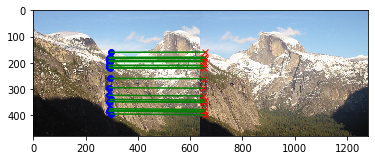

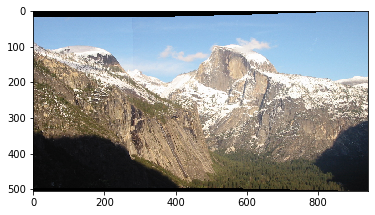

In [14]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY);

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.show()